Transmon-Cavity system 💡🏮
================================
The qubit is going to be somewhere, where it is you ask? In our case, inside a *resonant cavity*. Inside the cavity there are quantized modes of the electromagnetic field $|0>, |1>, |2>, \dots$ As we know from the quantum theory of light, the electromagnetic field is a quantum harmonic oscillator. The qubit (which is a transmon, so it acts as an artificial atom) interacts with the electromagnetic field and these interaction are described using the *Jaynes-Cummings model*.

### 👉 Imports

In [1]:
import sys
sys.path.insert(1, r'..') # Path to grape code, won't be a problem if it was downloaded from conda
import grape  # This is mine :)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt  # qutip is used only to easily define basic quantum operators and turn them into numpy ndarrays
import scipy.ndimage as ndi

plt.style.use("ggplot")

### 👉 Ladder operators
This time the operators become a bit more interesting. We know from quantum mechanics that if we have a system that is composed of two different quantum system, the Hilbert space of the system is the *tensor product* of the Hilbert spaces of the two systems composing it $V = V_1 \otimes V_2$. If we have an operator $\hat{A}$ on the first system $V_1$ and we want to "upgrade" it to be an operator on the full system we can take it's tensor product with the identity of the other system as $\hat{A}_{full} = \hat{A} \otimes \hat{\mathbb{1}}$ to get an operator on the full system that does the same thing as $\hat{A}$.

We'll now see how this applies to our system. Let's set that the first system is the qubit and the second system is the cavity. The qubit is simple and we've seen it before, it has the annihilation and creation operators $\hat{q}$ and $\hat{q}^\dagger$ which are $2 \times 2$ matrices. The cavity is more complicated than that, it has infinite levels, which is a bit of a problem to the computer as you might imagine. This is why we'll set a finite number $n_{cav}$ which is the number of levels in the cavity. Later we'll need to make sure that nothing interesting happens in the level higher than $n_{cav}$ (since in the physical world, there isn't a highest level), we'll use a constraint for that. The cavity ladder operators will be $\hat{a}$ and $\hat{a}^\dagger$.

The "upgraded" operators of the full system are thus $\hat{q} = \hat{q}_{qubit} \otimes \hat{\mathbb{1}}_{cavity}$ and $\hat{a} = \hat{\mathbb{1}}_{qubit} \otimes \hat{a}_{cavity}$ and their hermitian conjugates.

In [2]:
cavity_levels = 10
qubit_levels  = 2

# qubit operators
q = qt.tensor(qt.destroy(qubit_levels), qt.qeye(cavity_levels))
qd = q.dag()
# cavity operators
a = qt.tensor(qt.qeye(qubit_levels), qt.destroy(cavity_levels))
ad = a.dag()

# Turn qutip objects to numpy
q = np.array(q)
qd = np.array(qd)

a = np.array(a)
ad = np.array(ad)

### 👉 Hamiltonians ⚡
The Hamiltonians are more interesting as well, they are described by the **Janyes-Cummings model**. The time-independent Hamiltonian is divided into three parts: qubit, cavity and the interaction between them. For a qubit with transition frequency $\omega_q$, cavity mode with transition frequency $\omega_a$, and coupling between the transmon and the cavity $\chi$ (cross-Kerr coefficient) the Hamiltonian is
$$\hat{H}_0 = \underbrace{\omega_q\hat{q}^\dagger \hat{q}}_\text{qubit} + \underbrace{\omega_a\hat{a}^\dagger \hat{a}}_\text{cavity} + \underbrace{\chi\hat{a}^\dagger\hat{a}\hat{q}^\dagger\hat{q}}_{interaction}$$
The Hamiltonians of the microwave pulses are the same but know we'll also add new microwave control pulses to control the cavity, for a total of four control pulses

|        |&emsp;&emsp;&emsp;&emsp; I &emsp;&emsp;&emsp;&emsp; |&emsp;&emsp;&emsp;&emsp;&emsp;Q&emsp;&emsp;&emsp;&emsp;&emsp;|
|:------:|:--------------------------------------------------:|:-----------------------------------------------------------:|
|  qubit |  $\hat{H}_I^{qubit} = (\hat{q} + \hat{q}^\dagger)$ |  $\hat{H}_Q^{qubit} = (\hat{q} - \hat{q}^\dagger)\cdot i$   |
| cavity | $\hat{H}_I^{cavity} = (\hat{a} + \hat{a}^\dagger)$ | $\hat{H}_Q^{cavity} = (\hat{a} - \hat{a}^\dagger)\cdot i$   |

There are now four amplitudes, $\epsilon_{I / Q}^{qubit / cavity}(t)$ and the total Hamiltonian of the system is the sum:
$$\hat{H} = \hat{H}_0 + \epsilon_I^{qubit}(t) \hat{H}_I^{qubit} + \epsilon_Q^{qubit}(t) \hat{H}_Q^{qubit} + \epsilon_I^{cavity}(t) \hat{H}_I^{cavity} + \epsilon_Q^{cavity}(t) \hat{H}_Q^{cavity}$$
We seek to find optimal $\epsilon_I (t)$ and $\epsilon_Q (t)$

In [3]:
# Constants
omega_q = 1
omega_c = 1
chi     = 1

In [4]:
# time-independent Hamiltonians
H_q   = omega_q*qd@q   # qubit
H_c   = omega_c*ad@a   # cavity
H_int = chi*ad@a@qd@q  # interaction
H_0   = H_q+H_c+H_int  # total

# time-dependent Hamiltonians (microwave control pulses)
H_qI = qd + q       # qubit - I
H_qQ = (qd - q)*1j  # qubit - Q

H_aI = ad + a       # cavity - I
H_aQ = (ad - a)*1j  # cavity - Q

### 👉 Time variables ⏰
**T** is the total time, **Ns** is the number of time steps and **times** is array of all time steps

In [5]:
T     = 25
Ns    = 200
times = np.linspace(0.0, T, Ns)

### 👉 Initial and target states
Setting initial and target states. $|\psi_{initial}>\ =\ |g> \otimes |0>$ and $|\psi_{target}>\ =\ |e> \otimes |0>$

In [6]:
psi_initial = np.array(qt.tensor(qt.basis(qubit_levels, 0), qt.basis(cavity_levels, 0)))
psi_target  = np.array(qt.tensor(qt.basis(qubit_levels, 1), qt.basis(cavity_levels, 0)))

### 👉 Initial pulses guess
We treat the the drive amplitudes $\epsilon_I(t)$ and $\epsilon_Q(t)$ as step-wise constant function, with step size of $\frac{T}{Ns}$ and a total of $Ns$ steps. This is why, in code, each drive amplitude is a numpy ndarray of length Ns.

This time we are going to be smarter about our initial guess choice. In example one we simply guessed a random wave, which is problematic for several of reason. The main problem with a random initial guess is that it is very much not smooth. We want an initial guess that is close to 0, pretty random and somewhat smooth, this could be achieved by taking the convolution of a guassian with a random array.

In [7]:
def gaussian(size, sigma, amp, graph=False):
    gaussian_window = np.zeros(size)
    for x in range(size):
        gaussian_window[x] = amp * np.exp(-(x - size / 2 ** 2) / sigma ** 2)
        if graph:
            plt.figure()
            plt.plot(times[0:size], gaussian_window)
    return gaussian_window

In [8]:
gauss_win = gaussian(int(Ns/10), Ns/50, 1)

# --- randmoness amplitudes ---
rand_amp_qQ = 1/3000  # qubit I
rand_amp_qI = 1/3000  # qubit Q

rand_amp_aQ = 1/3000  # cavity I
rand_amp_aI = 1/3000  # cavity Q

# --- calculate convolutions ---
conv_qI = ndi.convolve((np.random.random(Ns) - 0.5)*2*rand_amp_qI, gauss_win, mode='wrap')  # qubit I
conv_qQ = ndi.convolve((np.random.random(Ns) - 0.5)*2*rand_amp_qQ, gauss_win, mode='wrap')  # qubit Q

conv_aI = ndi.convolve((np.random.random(Ns) - 0.5)*2*rand_amp_aI, gauss_win, mode='wrap')  # cavity I
conv_aQ = ndi.convolve((np.random.random(Ns) - 0.5)*2*rand_amp_aQ, gauss_win, mode='wrap')  # cavity Q

# --- assign initial guesses ---
e_qI = conv_qI  # qubit I
e_qQ = conv_qQ  # qubit Q

e_aI = conv_aI  # cavity I
e_aQ = conv_aQ  # cavity Q

### 👉 Constraints
We'll now define the strength of the constraints (the lagrange multipliers, $\lambda$'s). In this example we will only have soft constraint (instead of hard constraints such as cut-off amplitude and frequency). We'll only define constraints on the amplitude and the bandwidht, $\lambda_{amp}$ and $\lambda_{band}$.

In [9]:
lambda_amp = 0
lambda_band = 0.1

We need to put the multiple drive hamiltonians into one variable and also for the multiple drive amplitudes.
We set a variable, *drive_hamiltonians*, which is a list of all the drive hamiltonians, and a variable, *pulses*, which is a list of the drive amplitudes. Notice that the two lists need to be the same length and that the $i^{th}$ drive hamiltonian in the list correspond to the $i^{th}$ drive amplitude in the list

In [10]:
drive_hamiltonians = [H_qI, H_qQ, H_aI, H_aQ]
pulses    = np.array([e_qI, e_qQ, e_aI, e_aQ])

### 👉 Creating GRAPE object 🍇
We now create the *GrapePulse* object, which contains all the data on the pulse and can be used for the optimization

In [11]:
grape_pulse = grape.GrapePulse(psi_initial, psi_target, T, Ns, H_0, drive_hamiltonians,
                               pulses, constraints=True, lambda_amp_lin=lambda_amp, lambda_band_lin=lambda_band)

## 👉 Optimizing 🛠
We now run the GRAPE optimization, we can choose to graph the probabilites over the duration of the pulse before and after the optimization

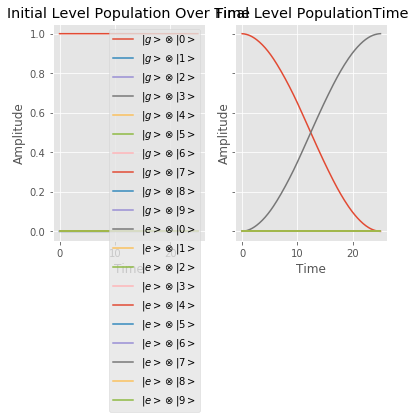

In [12]:
results = grape_pulse.optimize(graph_prob=True)

We get back a dictionary with all the results we need: optimized drive amplitudes, final fidelity, the Hamiltonians (which are allready known if you wrote this script, but usefull if you want to save it to a file), the Hilbert space dimensions and some comments you can add. The dictionary has the form:
* **"pulses"**: *ndarray* of shape (number of drive amplitudes$\ \times\ $number of time steps)
* **"fidelity"**: *float* of the final fidelity
* **"Hamiltonians"**:
    * **"constant"**: *ndarray* matrix of the constant hamiltonian
    * **"drives"**: *list of ndarray* matrices of the drive hamiltonians
* **"dimensions"**: *ndarray* of list of original hilbert space dimensions
* **"comments"**: comments you can add (again, only useful when you save as a file and want to understand what these results mean

### 👉 Graphing the results 📈

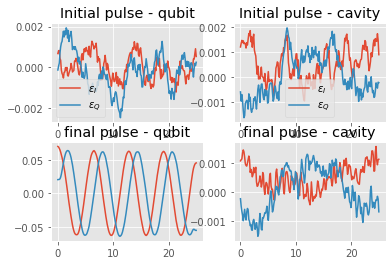

In [17]:
pulses = results["pulses"]

fig, axes = plt.subplots(2, 2)
# --- qubit ---
# --- Initial ---
axes[0,0].set_title("Initial pulse - qubit")
axes[0,0].plot(times, e_qI)
axes[0,0].plot(times, e_qQ)
axes[0,0].legend([r'$\epsilon_I$', r'$\epsilon_Q$'])
# --- Final ---
axes[1,0].set_title("final pulse - qubit")
axes[1,0].plot(times,  pulses[0])
axes[1,0].plot(times,  pulses[1])

# --- cavity ---
# --- Initial ---
axes[0,1].set_title("Initial pulse - cavity")
axes[0,1].plot(times, e_aI)
axes[0,1].plot(times, e_aQ)
axes[0,1].legend([r'$\epsilon_I$', r'$\epsilon_Q$'])
# --- Final ---
axes[1,1].set_title("final pulse - cavity")
axes[1,1].plot(times,  pulses[2])
axes[1,1].plot(times,  pulses[3])

Now we got smooth results as expected

### Checking final fidelity
One last thing we need to check is that the final fidelity is actually close to $1$, let's check that now

In [14]:
print("A fidelity of", results["fidelity"], "was achieved by the optimization")

A fidelity of 0.9988209049749559 was achieved by the optimization
